# MAST Plasma Equilibrium Prediction

This notebook shows how to predict two-dimensional poloidal flux maps from diagnostic measurements using EFIT++ equilibrium reconstruction code outputs to train and test models.

> **Note:** Run the `Plasma Equilibrium Dataset.ipynb` notebook first to download the dataset from the FAIR-MAST server. This will place the necessary data files in the `fair_mast_data/plasma_equilibrium` directory.

## Overview

This project addresses the third data science challenge from the ITER International School 2024 series. The challenge focuses on:

1. Applying signal selection techniques to diverse input sets
2. Implementing effective normalization strategies 
3. Predicting 2D spatial targets from 1D signal inputs

![Equilibrium Animation](../media/images/equilibrium.gif)

## Key Challenge Concepts

- **Signal Processing**: Process heterogeneous diagnostic signals from tokamak experiments
- **Dimensionality Transformation**: Transform 1D time-series inputs into 2D spatial maps
- **Validation Methods**: Evaluate flux map prediction accuracy with appropriate metrics

The EFIT++ code reconstructs plasma equilibrium by combining external and internal diagnostic measurements. The animation above shows poloidal flux contour evolution over time for one MAST shot from the training dataset. While displayed as mirrored for illustration, the plasma equilibria are axisymmetric on the poloidal r, z plane.

**Challenge Goal**: Predict 2D poloidal flux maps from diagnostic measurements.

The open-source MAST Data Catalog provides all data for this project. Credit to Samuel Jackson, Nathan Cummings, Saiful Khan, and the wider MAST community for curating this FAIR dataset.

## Description

Poloidal magnetic flux represents the integral of the vertical magnetic field component passing through a disc. This disc is bound by an r, z point on the poloidal plane and aligned with the z-axis. The unit of measurement is Weber (Wb).

In this challenge, you must predict:
1. The poloidal flux map shape
2. The flux values at specific time points

The training dataset contains 1D and 2D inputs from these MAST signal groups:
- magnetics
- spectrometer_visible
- soft_x_rays
- thomson_scattering

Success requires selecting optimal diagnostic groups and signals to maximize the fit between training data and unseen targets. This demands both intuition about signal meaning and systematic experimentation. Consider transforming input data to generate additional useful signals.

Note that signals span widely different scales. You must develop effective preprocessing to normalize inputs for good results.

Below, I compare EFIT++ ground truth with predictions from a simple linear regression model.

### Dataset Information

The data files are in the `./fair_mast_data/plasma_equilibrium` directory:

#### Available Files
- `train.nc` - Training dataset (netCDF format)
- `test.nc` - Test dataset (netCDF format)

These files use the netCDF format, optimized for scientific data. Use the `xarray` library to open and explore them. The Example section below demonstrates how to open, examine, and format this data.

## Example

We'll now import the necessary libraries for data processing, visualization, and machine learning.

In [1]:
# Standard library imports
import pathlib
from dataclasses import dataclass, field
from functools import cached_property

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import xarray as xr


Next, we load the training and test datasets from our project directory.

In [2]:
path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_equilibrium"

try:
    with (
        xr.open_dataset(path / "train.nc") as train,
        xr.open_dataset(path / "test.nc") as test,
    ):
        train = train.load()
        test = test.load()

except FileNotFoundError:
    raise FileNotFoundError(
        "Please run the `Plasma Equilibrium Dataset.ipynb` notebook to download the "
        "required dataset from the FAIR-MAST server")


Let's examine the dataset structure using xarray's capabilities. The `filter_by_attrs` function helps explore data by filtering on attributes:

In [3]:
print(train.filter_by_attrs(units="Wb"))  # all attributes with units of Weber
print(train.filter_by_attrs(units="V"))  # all attributes with units of Volts
print(train.filter_by_attrs(group="magnetics"))  # all attributes in the magnetics group


<xarray.Dataset> Size: 69kB
Dimensions:            (time: 533, flux_loop_channel: 15)
Coordinates:
  * flux_loop_channel  (flux_loop_channel) <U12 720B 'AMB_FL/CC03' ... 'AMB_F...
  * time               (time) float64 4kB -0.0656 -0.0606 ... 0.2938 0.2988
Data variables:
    flux_loop_flux     (time, flux_loop_channel) float64 64kB 0.1129 ... -0.0...
Attributes:
    description:  
<xarray.Dataset> Size: 470kB
Dimensions:                                   (time: 533,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               dalpha_channel: 3,
                                               horizontal_cam_lower_channel: 18,
                                               horizontal_cam_upper_channel: 18,
                                               b_field_tor_probe_omaha_channel: 4,
                                            

To identify all available groups in this dataset, run the following command:

In [4]:
print(np.unique([array.group for array in test.values() if hasattr(array, 'group')]))

['magnetics' 'soft_x_rays' 'spectrometer_visible' 'thomson_scattering']


In [5]:
def to_pandas(dataset: xr.Dataset, attrs: list[str]) -> pd.DataFrame:
    """Return set of Dataset attributes as a concatenated Pandas DataFrame."""
    return pd.concat([dataset[attr].to_pandas() for attr in attrs], axis=1)  # type: ignore[return-value]

### Data Preparation

For this example, we select only the `flux_loops` from our training set. Our process involves:

1. Extracting signals (X) and targets (y) from the dataset
2. Splitting data into training and test sets

We isolate one complete shot as our test set by filtering on the `shot_index` attribute. This creates a more coherent GIF animation for demonstration.

Consider whether this splitting strategy works best for your needs. What other ways might you divide this dataset?

Note: The poloidal flux map target has dimensions (time, z, major_radius). We must reshape it to (nsamples, nsignals) format for compatibility with machine learning libraries.

In [6]:
signals = ["flux_loop_flux"]  # select input signals
train = train[signals + ["psi", "shot_index"]]  # select input signals and target

train = train.dropna(dim="flux_loop_channel")  # drop nan channels
test = test.dropna(dim="flux_loop_channel")  # drop nan channels

train = train.dropna(dim="time")  # drop NaN values
X = to_pandas(train, signals)
y = train.psi.data.reshape((train.sizes["time"], -1))

# generate train and test set based on shot index
index = train.shot_index.values == 3
X_train, X_test, y_train, y_test = X[~index], X[index], y[~index], y[index]


### Model Training and Evaluation

With our data prepared, we can now:

1. Set up our processing pipeline
2. Fit the model to our training data
3. Evaluate its performance

Keep in mind that for this equilibrium reconstruction challenge, you should consider:
- Selecting more advanced models than simple linear regression
- Including data preprocessing steps
- Implementing hyperparameter tuning



In [7]:
# Create a simple pipeline with only LinearRegression
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.linear_model.LinearRegression()
)

# Train the model on training data
pipeline.fit(X_train, y_train)

# Generate predictions
y_pred = pipeline.predict(X_test)

# Calculate mean absolute error (lower is better)
error = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {error:.6f} Wb")


Mean absolute error: 0.003918 Wb


### Understanding Model Evaluation Metrics

#### Mean Absolute Error (MAE)

In the code above, we evaluate our model using the **Mean Absolute Error (MAE)** metric. Let's understand what this means in the context of our plasma equilibrium prediction task:

**What is MAE?**
MAE measures the average magnitude of errors between predicted and actual values, without considering their direction. Mathematically, it's calculated as:

$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

Where:
- $y_i$ represents the true flux value
- $\hat{y}_i$ represents the predicted flux value
- $n$ is the number of points being evaluated

**Why use MAE for this challenge?**

MAE is particularly suitable for the plasma equilibrium prediction task because:

1. **Physical Interpretation**: In the context of poloidal flux maps, MAE directly tells us the average absolute deviation (in Weber units) between our predicted flux values and the ground truth EFIT++ values across all grid points.

2. **Robustness**: Unlike Mean Squared Error (MSE), MAE is less sensitive to outliers, which can be important when dealing with plasma diagnostics that may occasionally have measurement spikes.

3. **Same Units**: MAE preserves the original units of our target variable (Weber), making the error value physically interpretable.

**Interpreting the MAE value:**
- Lower values indicate better model performance
- The theoretical best value is 0 (perfect prediction)
- The MAE should be considered in context of the range and physical meaning of the flux values

For reference, high-quality equilibrium reconstructions typically achieve MAE values in the order of 10^-3 to 10^-4 Weber when compared to ground truth. The exact threshold for "good performance" depends on the specific application and required accuracy for plasma control or analysis tasks.

### Making Predictions and Generating Submissions

After validating our model performance, we can generate predictions for the test dataset and prepare a submission file:

In [8]:
# Make predictions for the test dataset
psi = pipeline.predict(to_pandas(test, signals))

# Create and save submission file
submission = pd.DataFrame(psi)
submission.index.name = "index"
submission.to_csv(path / "submission.csv")


## Results Visualization

Visualizing the comparison between predictions and EFIT++ ground truth provides valuable insights. The helper class below creates these visualizations and animations.

In [9]:
@dataclass
class Contour:
    """Manage multiple contour plots."""

    magnetic_flux: xr.DataArray | None = None
    levels: int = 31
    _handles: list = field(init=False, repr=False, default_factory=list)

    @cached_property
    def axes(self):
        """Manage axes instance."""
        self.fig, axes = plt.subplots(figsize=(3, 4.5))
        axes.set_aspect("equal")
        axes.set_axis_off()
        return axes

    @cached_property
    def shape(self):
        """Return flux map 2D shape."""
        return self.magnetic_flux.sizes["z"], self.magnetic_flux.sizes["major_radius"]

    def plot(self, data: xr.DataArray | np.ndarray = None, label=None, **kwargs):
        """Create contour map from magnetic flux data, store contour levels."""
        if isinstance(data, xr.DataArray):
            self.magnetic_flux = data
            data = data.values
        kwargs = {"colors": "gray", "linestyles": "-", "levels": self.levels} | kwargs
        try:
            contour = self.axes.contour(
                self.magnetic_flux.major_radius,
                self.magnetic_flux.z,
                data.reshape(self.shape),
                **kwargs,
            )
        except AttributeError:
            raise AttributeError(
                "Grid coordinates major_radius and z not found on "
                "magnetic_flux DataArray."
            )
        self.levels = contour.levels
        if label:
            color = kwargs.get("colors", "gray")
            self._handles.append(
                plt.matplotlib.lines.Line2D([0], [0], label=label, color=color)
            )
        return contour

    def legend(self):
        """Add legend to plot."""
        plt.legend(
            handles=self._handles, loc="center", bbox_to_anchor=[0.5, 1.08], ncol=1
        )
        self._handles = []

    def __call__(self, efit: np.ndarray, prediction: np.ndarray):
        """Plot a comparison between EFIT++ ground truth and prediction."""
        return [
            self.plot(efit, colors="gray", label="EFIT++"),
            self.plot(prediction, colors="C0", label="Prediction"),
        ]

    def _next_image(self, efit: np.ndarray, prediction: np.ndarray) -> PIL.Image.Image:
        """Yield poloidal flux contour images."""
        del self.axes  # clear instance axes
        self._handles = []  # clear legend handles
        self.levels = np.linspace(efit.min(), efit.max(), 51)
        contours = self(efit[-1], prediction[-1])
        self.legend()
        for _efit, _prediction in zip(efit, prediction):
            for contour in contours:
                contour.remove()
            contours = self(_efit, _prediction)
            self.fig.canvas.draw()
            yield PIL.Image.fromarray(np.array(self.fig.canvas.buffer_rgba()))

    def to_gif(self, efit: np.ndarray, prediction: np.ndarray):
        """Save gif animation of frame-wise efit-prediction mapping."""
        imgs = [image for image in self._next_image(efit, prediction)]
        imgs[0].save(
            path / "equilibrium_animation.gif",
            save_all=True,
            append_images=imgs,
            duration=100,
            loop=0,
            minimize_size=True,
        )


### Using the Contour Class

To use the visualization tools, we first initialize the `Contour` class with a `magnetic_flux` DataArray. This DataArray should contain the magnetic flux values on a poloidal grid. The `Contour` class uses this information to create contour plots of the magnetic flux. 

Here is an example of how to initialize the `Contour` class:

```python
from your_module import Contour
import xarray as xr

# Assuming magnetic_flux_data is your DataArray containing magnetic flux values
contour = Contour(magnetic_flux_data)
```

Once the `Contour` class is initialized, you can use its methods to create various visualizations of the magnetic flux. For example, to create a basic contour plot, you can use the `contour_plot` method:

```python
contour.contour_plot()
```

This will generate a contour plot of the magnetic flux on the poloidal grid. You can customize the plot by adjusting the parameters of the `contour_plot` method. For example, you can change the contour levels, add labels, and modify the color map. 

Refer to the documentation of the `Contour` class for more details on the available methods and their usage.

Individual frames at a specific time index can be visualized by calling an instance of the contour class with test and prediction targets:

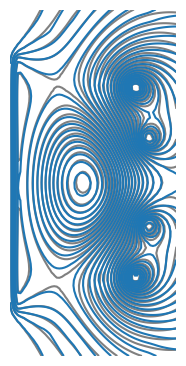

In [10]:
contour = Contour(train.psi)

time_index = 50
sns.set_context("notebook")
contour(y_test[time_index], y_pred[time_index])


To visualize the temporal evolution of your model's predictions, you can generate a GIF animation by calling the `to_gif` function with the complete test and prediction arrays.

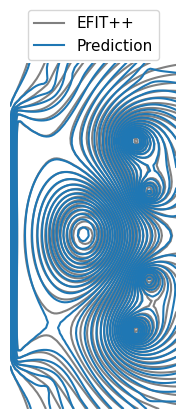

In [11]:
contour.to_gif(y_test, y_pred)

### Animation: Comparison of Model Predictions to Ground Truth

The animation below shows how our model predictions (blue) compare to the EFIT++ ground truth (gray) over time:

![Equilibrium Animation Comparison](../fair_mast_data/plasma_equilibrium/equilibrium_animation.gif)

## Model Assessment and Next Steps

Our simple linear regression model provides a baseline for plasma equilibrium reconstruction. However, there are several improvements we can make to enhance performance, ranging from simple techniques to more advanced approaches.

### Simple Improvements with scikit-learn

These recommendations can be implemented using the current dataset and scikit-learn library:

1. **Multiple Diagnostic Signal Integration**:
   - Including signals from multiple diagnostic groups (magnetics, soft_x_rays, thomson_scattering) significantly improves reconstruction accuracy compared to using a single group
   - Combining complementary information from different measurement systems helps capture more aspects of the plasma state
   - Feature importance analysis can identify which diagnostic signals contribute most to accurate reconstructions

2. **Filtering Strategies Based on Rate of Change of Plasma Current**:
   ```python
   def calculate_didt(time_series, plasma_current):
       """Calculate rate of change of plasma current."""
       return np.gradient(plasma_current, time_series)

   def apply_didt_filter(X, y, time, plasma_current, threshold=1e5):  # threshold in A/s
       """Filter training data based on rate of change of plasma current."""
       didt = calculate_didt(time, plasma_current)
       stable_indices = np.abs(didt) < threshold
       return X[stable_indices], y[stable_indices]
   ```

   This approach enables:
   - Regime separation for training separate models for "slow evolution" versus "fast transient" phases
   - Improved signal quality by filtering out noisy transient periods
   - Better physical consistency as stable periods follow MHD equilibrium more closely

3. **Enhanced Preprocessing**:
   - Apply standard scaling to normalize heterogeneous diagnostic signals
   - Use robust scaling for signals with outliers
   - Implement feature selection to identify the most informative signals
   ```python
   from sklearn.preprocessing import StandardScaler, RobustScaler
   from sklearn.feature_selection import SelectKBest, f_regression
   
   # Example pipeline with preprocessing
   pipeline = sklearn.pipeline.make_pipeline(
       RobustScaler(),
       SelectKBest(f_regression, k=20),  # Select top 20 features
       sklearn.linear_model.Ridge(alpha=0.1)  # Regularized regression
   )
   ```

4. **Model Selection and Tuning**:
   - Explore regularized models (Ridge, Lasso) to handle high-dimensional data
   - Use non-linear models such as RandomForest or GradientBoosting
   - Implement cross-validation and hyperparameter tuning
   ```python
   from sklearn.model_selection import GridSearchCV
   from sklearn.ensemble import GradientBoostingRegressor
   
   # Example grid search
   param_grid = {
       'gradientboostingregressor__n_estimators': [50, 100, 200],
       'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
       'gradientboostingregressor__max_depth': [3, 5, 7]
   }
   
   pipeline = sklearn.pipeline.make_pipeline(
       StandardScaler(),
       GradientBoostingRegressor()
   )
   
   grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error')
   grid_search.fit(X_train, y_train)
   ```

### Advanced Approaches (Requiring Custom Code)

These approaches would require more significant custom implementation beyond scikit-learn:

1. **Physics-Informed Machine Learning**:
   - Incorporate MHD equilibrium constraints (∇p = j × B) into model architecture
   - Use variational autoencoders to learn physically consistent equilibrium representations
   - Apply transfer learning from simulated equilibria to experimental data

2. **Advanced Signal Processing**:
   - Apply wavelet transforms to identify and filter transient events
   - Use Kalman filtering to track equilibrium evolution with physical constraints
   - Implement sensor fusion techniques to optimally combine heterogeneous diagnostic signals

3. **Passive Current Modeling**:
   - Model vessel geometry and electrical properties to account for passive currents
   - Develop eddy current evolution models with appropriate time constants
   - Use measurement redundancy to disambiguate plasma versus passive current effects

4. **Deep Learning Approaches**:
   - Implement neural networks with convolutional layers for spatial structure learning
   - Use recurrent neural networks (LSTM/GRU) to capture temporal evolution
   - Develop physics-constrained loss functions that enforce known plasma behavior

5. **Sophisticated Validation**:
   - Cross-validate against other equilibrium codes (EFIT, CLISTE, LIUQE)
   - Compare with direct internal measurements (Thomson scattering, MSE)
   - Evaluate reconstructions against known plasma physics constraints

### Physical Considerations

Understanding these physical aspects can guide model development:

1. **Plasma Current Distribution Assumptions**:
   - Axisymmetry around the toroidal axis (neglects 3D effects)
   - Current profile smoothness (may not capture sharp gradients)
   - Time independence between consecutive time points
   - Fixed boundary constraints for the plasma current

2. **Passive Current Effects**:
   - Passive currents generate confounding magnetic field signals
   - Time-dependent evolution differs from plasma current dynamics
   - Complex 3D spatial distribution affects measurements

By implementing the simpler improvements first and gradually incorporating more advanced techniques as needed, we can systematically enhance the accuracy and reliability of plasma equilibrium reconstruction from magnetic measurements.

# 1. Multiple Signal Dignostic Integration

### a. Bigger dataset

### b. Features analysis

# 2. Filtering strategy

In [ ]:
def calculate_didt(time_series, plasma_current):
       """Calculate rate of change of plasma current."""
       return np.gradient(plasma_current, time_series)

   def apply_didt_filter(X, y, time, plasma_current, threshold=1e5):  # threshold in A/s
       """Filter training data based on rate of change of plasma current."""
       didt = calculate_didt(time, plasma_current)
       stable_indices = np.abs(didt) < threshold
       return X[stable_indices], y[stable_indices]

# 3. Preprocessing

In [ ]:
   from sklearn.preprocessing import StandardScaler, RobustScaler
   from sklearn.feature_selection import SelectKBest, f_regression
   
   # Example pipeline with preprocessing
   pipeline = sklearn.pipeline.make_pipeline(
       RobustScaler(),
       SelectKBest(f_regression, k=20),  # Select top 20 features
       sklearn.linear_model.Ridge(alpha=0.1)  # Regularized regression
   )

# 4. Model selection and tuning

In [ ]:
   from sklearn.model_selection import GridSearchCV
   from sklearn.ensemble import GradientBoostingRegressor
   
   # Example grid search
   param_grid = {
       'gradientboostingregressor__n_estimators': [50, 100, 200],
       'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
       'gradientboostingregressor__max_depth': [3, 5, 7]
   }
   
   pipeline = sklearn.pipeline.make_pipeline(
       StandardScaler(),
       GradientBoostingRegressor()
   )
   
   grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error')
   grid_search.fit(X_train, y_train)

# ADVANCED APPROCHE